# 一次変換と matplotlib

線形写像について、また、複素平面について、
プログラムを通じて勉強しましょう。


行列 A が与えられた時に、$det(A - \lambda I) = 0$ となる $\lambda$ のことを固有値、それぞれの $\lambda$ に対して、
$A \vec x = \lambda \vec x$ となる $\vec x$ のことを固有値 $\lambda$ の固有ベクトルといいます。numpy には、linalg.eig という，固有値と固有ベクトルを返してくれる関数があります。この関数は、(固有値のベクトル, 
固有ベクトルを並べてできた行列(各列が固有ベクトル))というタプルを返します。ですので、2 つの変数のペアで返値を受け取れば，それぞれをとってこれます。

In [100]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
a = np.array([[1,0],[-0.5,2]])
e, v = np.linalg.eig(a)
print(e)
print(v)

[2. 1.]
[[0.    0.894]
 [1.    0.447]]


v は，固有ベクトルのリストではなく，v の各列が固有ベクトルだということに注意してください。この場合，固有値は 2 と 1 で，2 の固有ベクトルは [0,1] 1 の固有ベクトルは [0.894, 0.447] です。 

** 練習問題 **
2 次元の場合で、固有値、固有ベクトルを計算するプログラムを自分でも書いてみよう。高次元になると、方程式が高次になるので、ニュートン法などで方程式を解くなどのことを考える必要があります。

固有値，固有ベクトルの意味を考えるために，画像に対する，これらの変換による一次変換を考えてみましょう。

Python では、画像処理に、Pillow (PIL) パッケージが広く使われています。
画像を表示するだけなら、PIL パッケージに属する Image モジュールを用いて、次のようにして簡単にできます。
この import 文で、これ以降、このモジュールが Image という名前でアクセスできます。
Image.open により、画像ファイルに対応した Image オブジェクトが作られます。このオブジェクトは、
show メソッドでウィンドウを開いて表示できます。

In [103]:
import PIL.Image as Image

im = Image.open("./logo.png")
im.show()

PIL モジュールには、ImageDraw モジュールもあり、Image に対する描画ができます。ImageDraw.Draw 関数で返されるのは、
この画像に対する描画を担当する ImageDraw クラスのオブジェクトで、それに対して line などのメソッドを呼び出すことに
より、描画ができます。line は、第1引数でリストとして座標が与えられた2点を結ぶ線をひくものです。クラスやオブジェクトについての説明は、次回にまわします。

後の描画をわかりやすくするために，格子線をひいておきます。

In [19]:
from PIL import Image,ImageDraw

im = Image.open("./logo.png")
draw = ImageDraw.Draw(im)
w, h = im.size  # 500x 500のはず
for i in (list(range(0, 500, 125)) + [499]):  
                # range には + はできないので、list に一旦変換
    draw.line([i,0,i,500],fill="black",width=3)
    draw.line([0,i,500,i],fill="black",width=3)
im.show()

さらに、im を、np.asarray でピクセルの配列に変換し，
matplotlib で表示しましょう。


(500, 500, 4)


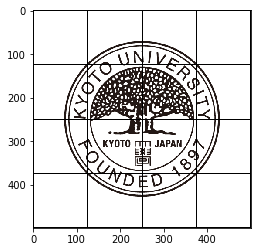

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

imarray = np.asarray(im)

#imarray は，画像のサイズ x 4 の rgba の配列
print(imarray.shape)

plt.imshow(imarray, aspect="equal")
plt.show()

これからの処理のために、x, y の座標が[0,500]x[0,500] ではなく，[-1,1]x[-1,1] 上の画像となるようにしましょう。
もともと白黒画像なので，黒となっている[-1,1]x[-1,1]　の点のリストとして表現しなおしてやります。

imarray の shape を見ればわかるように、imarray は(500,500,4) の3次元配列です。
imarray(x,y,a) は，各点の色の a 成分 (a = 0,1,2,3 は，r(赤), g(緑), b(青), alpha（透明度）) を表しています。
a = 0, すなわち，alpha成分だけとってきた2次元配列を fst としましょう。(他の成分では draw.line で描いた線がうまく出ないようです。)
そして，fst[x,y] が 0 でない点の座標 (x, y) だけを取り出して，それを
[-1,1]x[-1,1] の範囲に座標変換した値 (x, y) のリスト original を作ります。
numpy で操作するには，タプルのリストではなく，x, y 成分を0行目，1行目にもつ２次元配列にする必要があります。
x 成分，y 成分だけの配列 imagex, imagey を作り，それらからなる ndarray である image を作ります。

In [113]:

# 第3成分だけをとってくる。
fst= imarray[:,:,3]

#(x, y) の点が 0 でない（つまり，色がついている）所の座標を [-1, 1]x [-1,1] に変換した座標のリストを作る。
original = [((y-250)/250,((250-x)/250)) for x in range(500) for y in range(500) if fst[x,y] != 0]

#その x　成分，y 成分の配列のペアとなる配列を作る
image = np.array([[x for (x,y) in original],
                  [y for (x,y) in original]])
image

array([[-1.   , -0.996, -0.992, ...,  0.988,  0.992,  0.996],
       [ 1.   ,  1.   ,  1.   , ..., -0.996, -0.996, -0.996]])

次に定義する showimage は、x 座標、y 座標の2つの1次元配列として点の列が与えられて、それをプロットするものです。ただし、座標は [-1,1] か、それに近い大きさの数です。(x, y) という、x, y のペアをタプルで作りそれのリストにしたいところですが、numpy の行列演算を用いて処理するために、このようにして点のリストを与えます。

matplotlib の scatter は，与えられた座標に点をうつものですが，第1引数，第2引数に，x, y 座標の他に，
x 座標の配列, y 座標の配列をとることもできます。しかし，これらをまとめた配列(すなわち img ) をとることはできません。2 引数をとる関数に，tuple を適用するのに，`*` をつければいいということは以前学びましたが，同じことは，ndarray でもできます。よって，scatter の引数に *image をわたしています。

subplot をとってくるのは，この方が，座標軸を描画区域の外ではなく，絵の中に描くのに，subplots で部分絵に対する描画にして，座標軸 ax をとってくる必要があると思えるからです。
本質は上３行で，あとは座標軸の描画関係なので，無視して大丈夫です。

matplotlib は，最後に plt.show() により描画を行いますが，notebook の場合には，セルの最後に行ってくれます。その方が、showimage の後に行う描画と一緒に一つの画面に行えて便利なので，show なしで利用します。




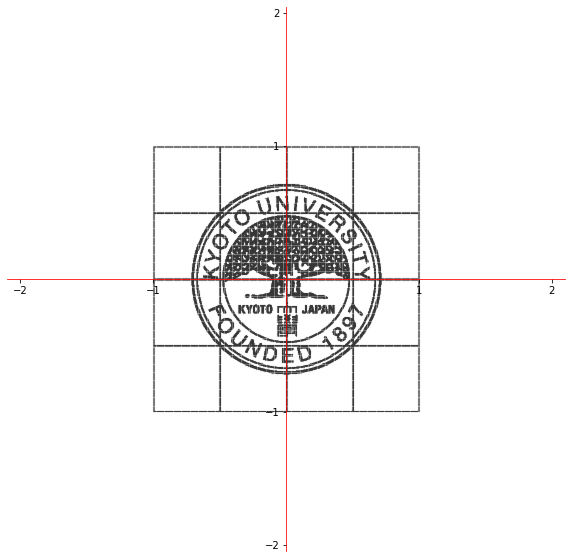

In [112]:
def showimage(image, size=2):
    """ image で与えられた点の集まりを全て plot した図を作る。size は描画する範囲が
    ([-size,size]x[-size,size])になるように指定。"""
    fig, ax = plt.subplots(figsize=(size*5,size*5))
    ax.set_aspect('equal', 'datalim') #x 軸と y 軸の目盛りを同じ幅にする。
    plt.scatter(*image, s=0.01, c="black")  # 0,01 は点のサイズ。
    
    #表示範囲の設定
    ax.set_ylim([-size-0.1,size+0.1])
    ax.set_xlim([-size-0.1, size+0.1])
    # 座標軸の設定(面倒だが、左と下ではなく、座標軸に数を入れるのに、他にいい方法はなさそう)
    for d in ['bottom', 'left']:
        ax.spines[d].set_position(('data', 0))
        ax.spines[d].set_color('red')
    ax.set_xticks([-2,-1,1, 2])
    ax.set_yticks([-2,-1,1, 2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#    plt.show()

  
showimage(image)

image という ndarray には，
元と同じ画像が，[-1,1]x[-1,1] の範囲で作られていることが分かります。さて，image には黒い点の x座標, y 座標の列からなる配列がはいっています。
それに座標変換を行い，絵がどうなるか見てみましょう。
座標変換後の x座標, y 座標の列からなる配列を得るには，変換行列を左からかければいいはずです。

よって，次のようにして，行列で変換した点を表示できます。ここでは，a は，x 成分を2倍，y 成分はそのままという一次変換行列です。

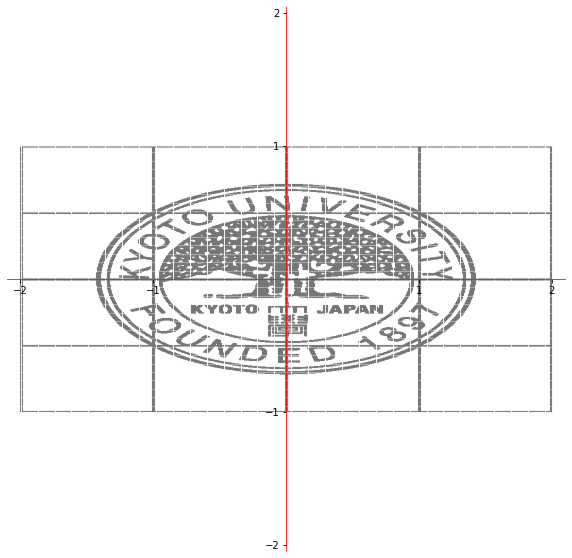

In [23]:
a = np.array([[2,0],[0,1]])
newfig = a@image
showimage(newfig)


**練習問題10** 与えられた t に対して，t だけの回転行列を返すメソッドを作ろう。それをかけることにより，image を回転させた絵を作成し，描画しよう。


**練習問題20** 行列 `[[a,b][c,d]]` による一次変換を行うと，(1,0) が (a,c), (0,1) が (b,d) に移ります。
そのことが分かるように，行列 v をもらい，その行列で image を一次変換した画像の上に，(a,c) および (b,d) に，赤および青の点をうった絵を描く，trans(v) を作ろう。
点は，matplotlib　の scatter 関数で打つことができる。また，matplotlib は，show を呼び出さないと、セルにある描画命令をまとめて実行してくれるので，showimage の後に，これを行えばよい。
showimage の第2引数で size を渡すと，描画範囲を [-size,size]x[-size,size] にできる。v をもとに，適切な値をshowimage にわたして，画像が画面内に収まるようにしよう。


trans を用いて、いろんな行列の一次変換の結果を描画しよう。

**練習問題30** 角度 30 の回転行列

**練習問題35** t = 30 とし、(cos(t), sin(t)) と原点を結ぶ直線に対する折り返し。(-t 度回転し、x 軸で折り返し、t 度すればよい。)
(-2cos(t),-2sin(t)) と (2cos(t), 2sin(t)) を結ぶ線分も描こう。2点 [x0,y0], [x1,y1] を結ぶ青色の線分で幅が3 のものは，

```plt.plot([x0,x1], [y0,y1], 'b-', lw=3) ```

で描くことができる。


**練習問題40**  A = [[1, 0.2],[0.5, 1]], A の 2乗，A の3乗。
行列 a の n 乗は，
```
np.linalg.matrix_power(a, n) 
```
で求まる。

**練習問題50**  A = [[1,0],[-0.5,1]],
A の 2乗，A の 3 乗。　　　

**練習問題60** 
trans を，固有値を表示し，固有値が実数の時には，原点を始点とする固有ベクトルも描画するように変更した，eigen(a) を作成しよう。x が実数かどうかは，type(x) == complex で調べることができる。上の練習問題のそれぞれの行列に対して新しい eigen を行い，固有値と固有ベクトルの意味を確認しよう。


**練習問題70** 
最大の固有値に対応する固有ベクトルが X 軸に来るように、図形を回転させよう。

**練習問題80** (xx, yy) をもらい，xx, yy だけ平行移動を行うにはどうすればよいか考えましょう。
それは，(x, y) の代わりに (x, y, 1) を考えて，　
`[[1,0,xx],[0,1,yy]]` という行列との掛け算をすればよいはずです。figx の長さは，
`figx.shape[0]` でとって来れます。また，[1,1,1...,1] という大きさ n のリストは [1]*n　でできます。

## 複素数

複素数は，平面上の点と１対１に対応します。そして，複素関数
$y = f(x)$ は，平面上の点を点に，図形を図形に移す写像となります。解析的（無限回微分可能）な複素関数が作る変換は，きれいな特徴を持っています。

original は，点を表す (x, y) というペアのリストだったので，次で，対応する複素数の ndarray が作れます。

In [114]:
imagec = np.array([complex(*t) for t in original])

後で割り算をする都合で，0 だけ，消しておきましょう。

In [116]:
print(np.where(imagec == 0))
print(len(imagec))
imagec = np.delete(imagec, np.where(imagec == 0))
print(len(imagec))

(array([32436]),)
52717
52716


それを画面表示するには，次のようにすればいいでしょう。
plt は複素数に対応していないので，実数部分と虚数部分の２つのリストを作ってから scatter に渡しています。

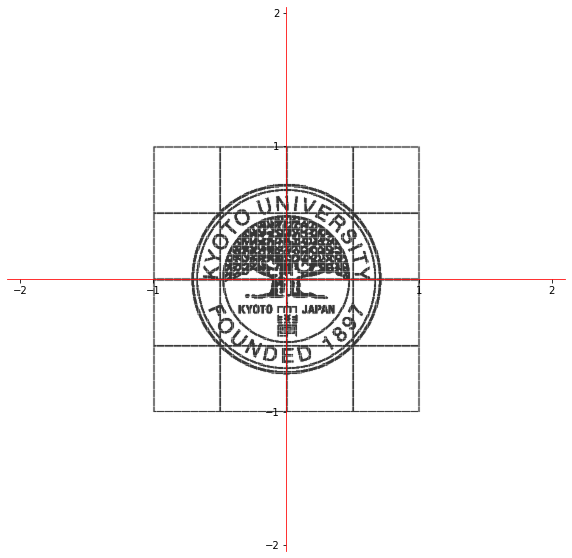

In [117]:
def showcimage(cimage, size=2):
    """ image で与えられた点の集まりを全て plot した図を作る。size は描画する範囲が
    ([-size,size]x[-size,size])になるように指定。"""
    fig, ax = plt.subplots(figsize=(size*5,size*5))
    ax.set_aspect('equal', 'datalim') #x 軸と y 軸の目盛りを同じ幅にする。
    plt.scatter([x.real for x in cimage], [x.imag for x in cimage], s=0.01, c="black")  # 0,01 は点のサイズ。
    
    #表示範囲の設定
    ax.set_ylim([-size-0.1,size+0.1])
    ax.set_xlim([-size-0.1, size+0.1])
    # 座標軸の設定(面倒だが、左と下ではなく、座標軸に数を入れるのに、他にいい方法はなさそう)
    for d in ['bottom', 'left']:
        ax.spines[d].set_position(('data', 0))
        ax.spines[d].set_color('red')
    ax.set_xticks([-2,-1,1, 2])
    ax.set_yticks([-2,-1,1, 2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#    plt.show()

showcimage(imagec, 2)  


複素数の掛け算は回転と拡大・縮小を表します。

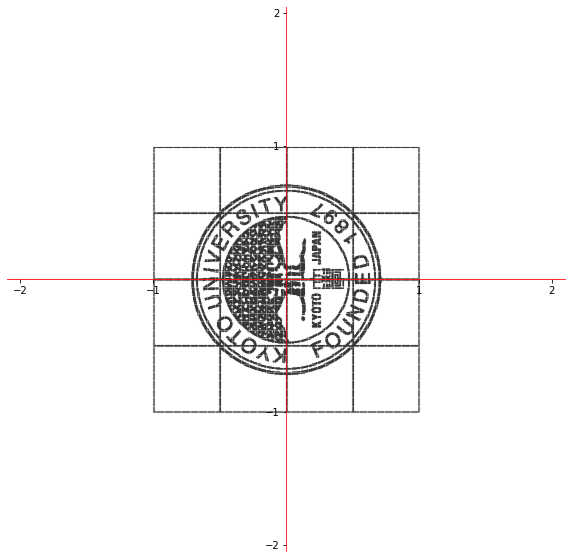

In [118]:
showcimage(imagec*1j)  


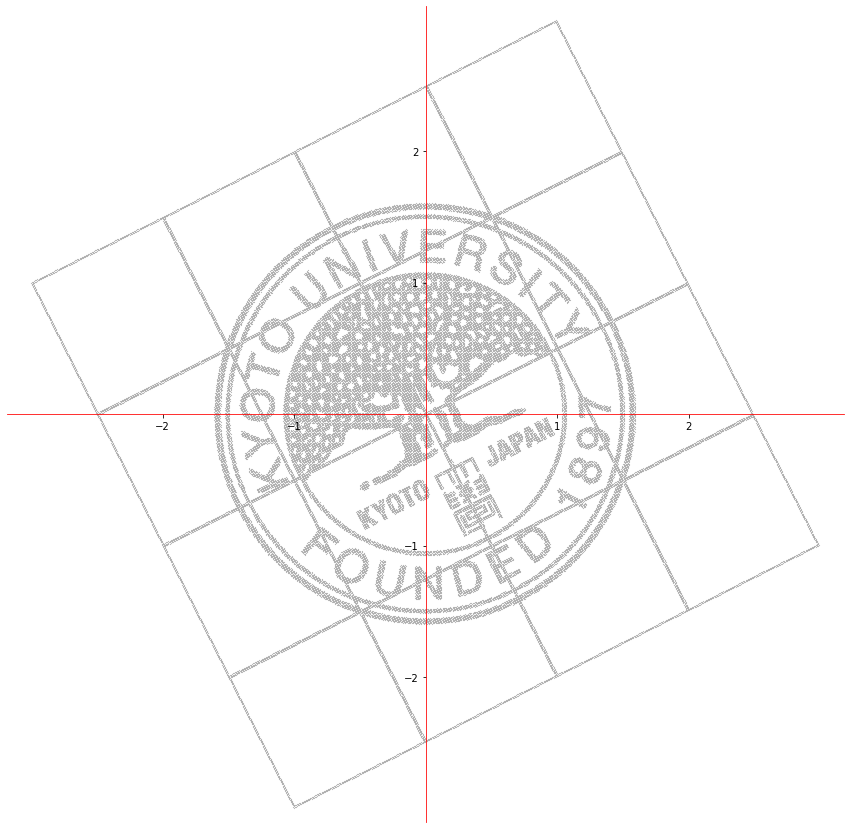

In [119]:
showcimage(imagec*(1j+2),3)  

1/x は，単位円に関してひっくり返して，さらに，複素共役をとります。
だから，np.conjugate(1/x) で，単位円に関してひっくり返すことになります。
直線でなく，円に対して対象というのは分かりにくいでしょうが，x 軸上で  x と 1/x の関係を考えて，絵を見て直感的に感じてください。

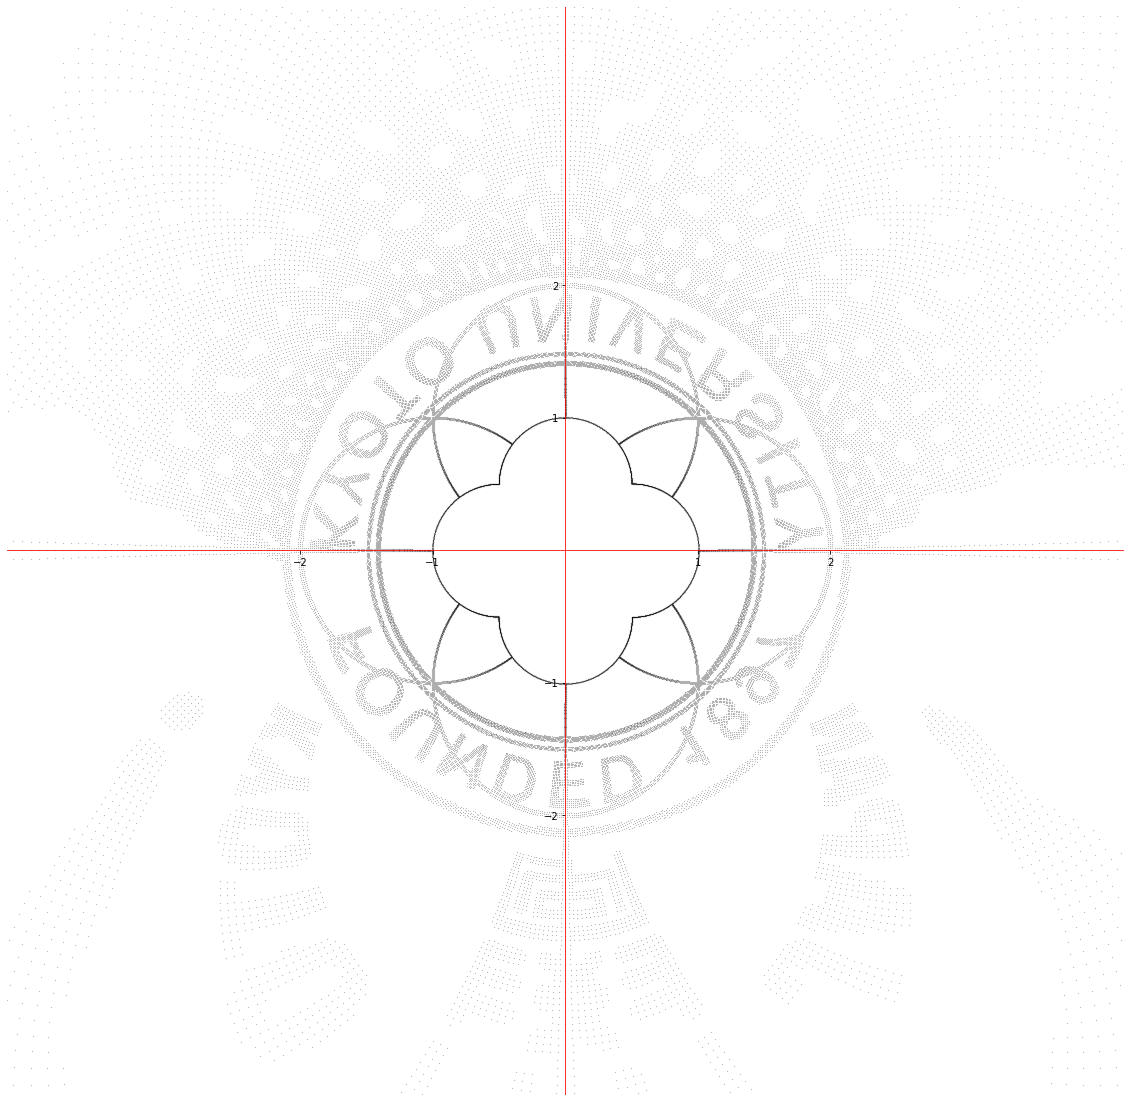

In [120]:

showcimage(np.conjugate(1/imagec), 4)  

##imagec を青で描画
#import math
#plt.scatter([x.real for x in imagec], [x.imag for x in imagec], s=0.01, c="green")  # 0,01 は点のサイズ。

## 単位円を赤で描画
#x = []
#y = []
#for j in np.linspace(0, 2 * np.pi, 1000):
#      x.append(math.sin(j))
#      y.append(math.cos(j))
#plt.plot(x,y, c="red")


元の絵を，複素単位 i だけ下にずらして，x 軸より下だけにして
1/x をとってみましょう。0 で割り算の warning は気にしないでいきましょう。


/Users/tsuiki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/tsuiki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


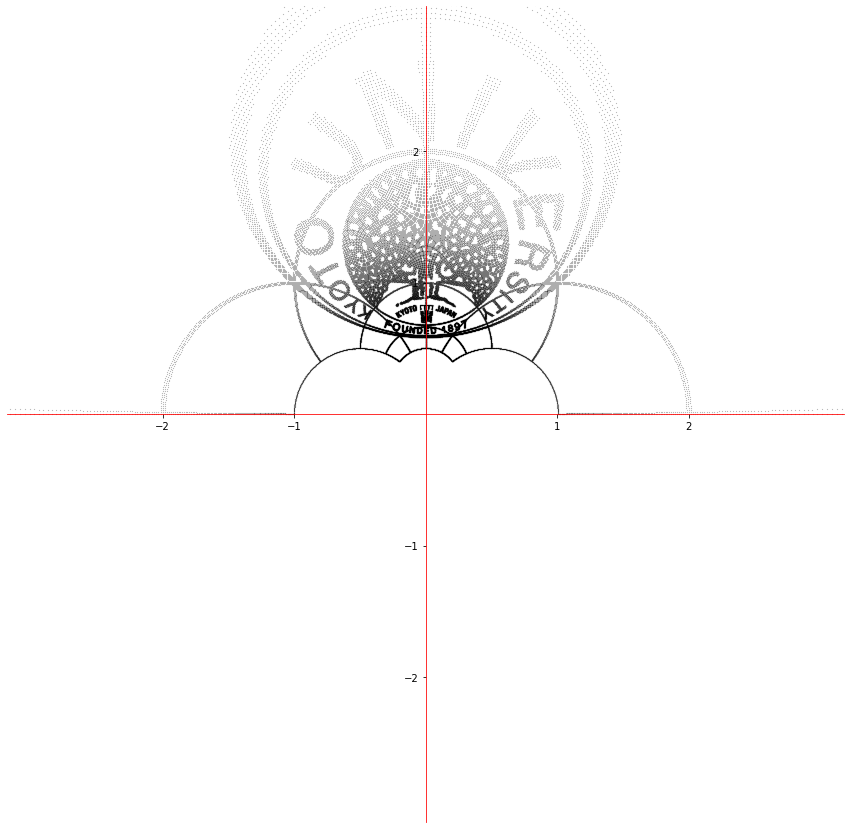

In [121]:
showcimage((1/(-1j+imagec)), 3)  

f(x) = x**2 は，1:2 の写像なので，2重になってしまうので，ちょっと複雑です。

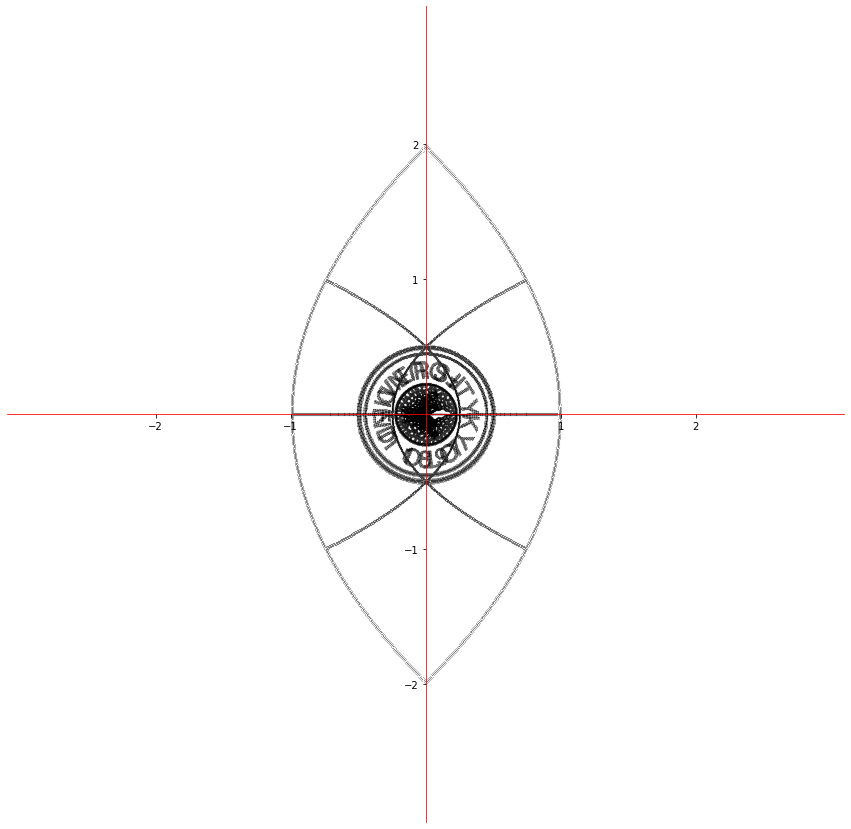

In [122]:
showcimage(imagec ** 2, 3) 

2 重にならないように，1 を足して，元の絵を y 軸の右側だけに
もっていって行いましょう。元の絵を，y 軸が x 軸のマイナス部分にくるように
引き伸ばした絵になっているのがわかりますか？

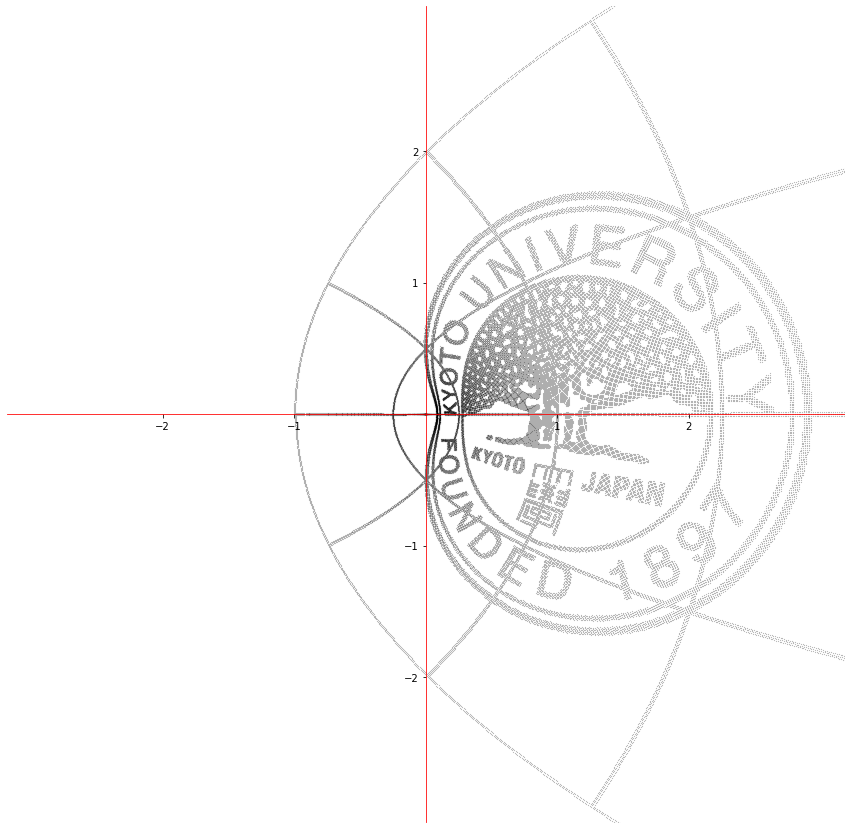

In [123]:
showcimage((1+imagec) ** 2, 3) 

逆の sqrt は，x 軸のマイナス部分で切ってそれが y 軸にくるまで伸ばした感じです。原点周りが薄くなっているように，原点の周りは引き伸ばされています。

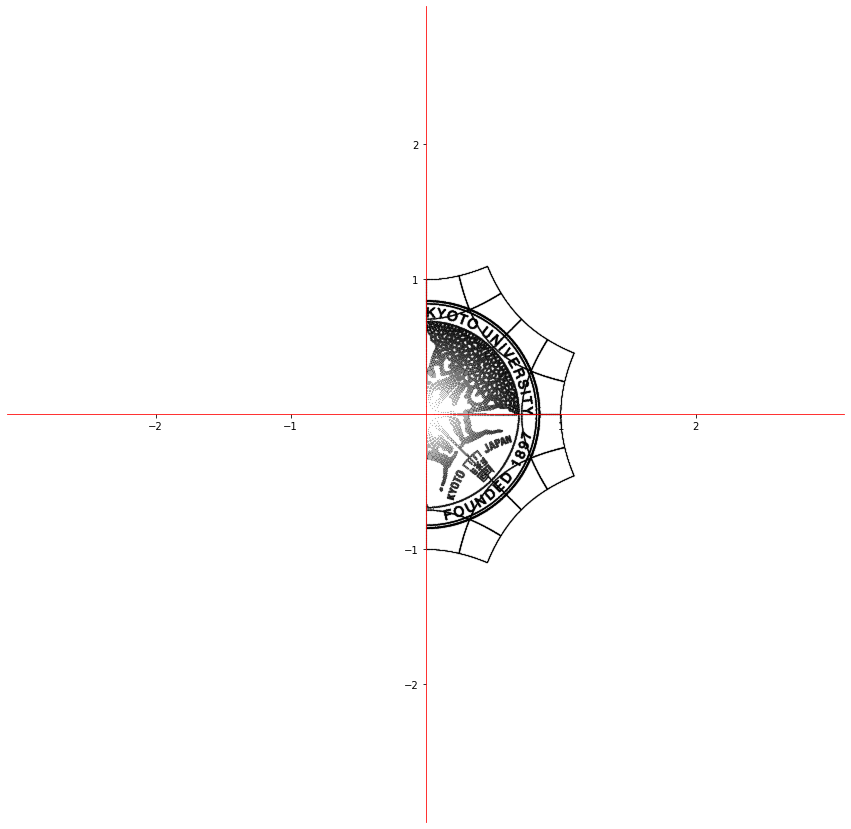

In [124]:
import cmath
showcimage([cmath.sqrt(x) for x in imagec], 3) 

メビウス変換（一次の分数写像）は，複素平面に無限遠点を加えたところ(無限遠をz = 1 の所にしたリーマン球面を考えるとわかりやすいです）で考えると，１対１の写像になっています。次の写像は，
1 が0 に，0 が -1 に，-1 が無限大に，無限大が 1 になっています。つまり，リーマン球面を，y 軸の周りで 90 度回転させています。

/Users/tsuiki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/tsuiki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


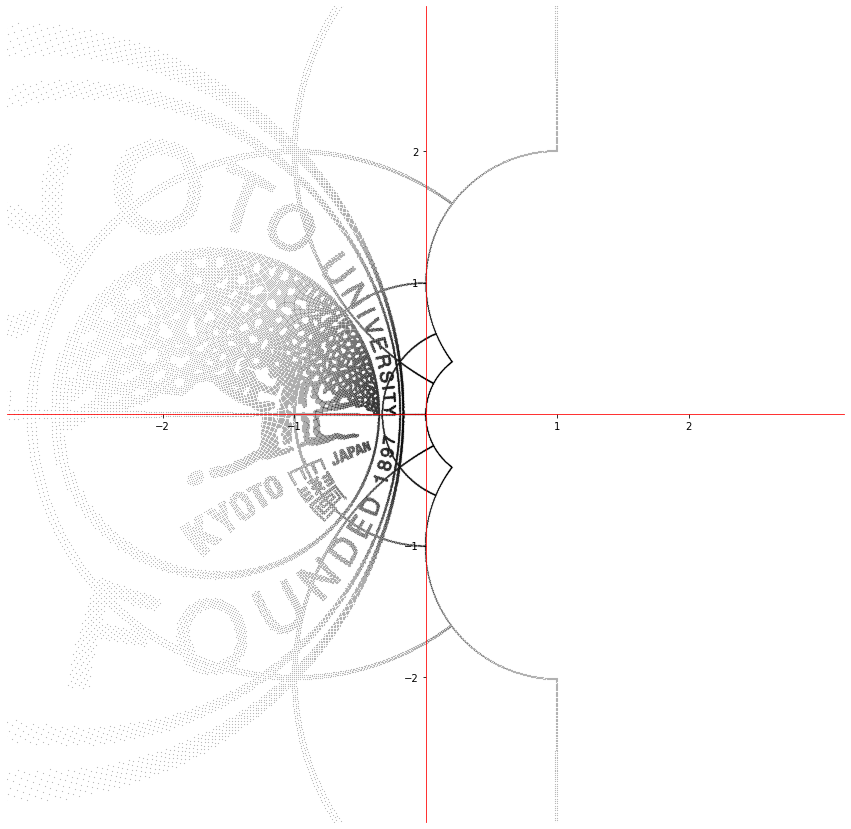

In [125]:
showcimage((imagec-1)/(imagec+1), 3) 

$y = e^x$ は次のようになります。

showcimage(np.exp(imagec), 3)  

（解析的な）複素関数をかけても，字が自然に読めるのが不思議ではありませんか？これは，変換結果をずっと拡大して，ローカルに見たら，形を変えていないことに由来しています。直交した曲線は，直交した曲線に移ります。

**練習問題** いろんな関数について，図示してみよう。

**練習問題** 今の絵の書き方では，拡大率の大きい所は薄くなってしまいます。拡大率の大きなところも薄くならなくすることも，結果の絵の方からはじめて，それがもともとどの点から来てたか（つまり，逆関数）を考えて描画すればできるはずです。そのように，書き換えてみましょう。